In [1]:
import numpy as np
import pandas as pd
import os
import re

import pyedflib

from scipy.signal import welch

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
from bhtsne import tsne
from MulticoreTSNE import MulticoreTSNE as TSNE_Multi

In [2]:
def generateEEGdataDF(file, fft_seg_length):
#this function loads the data files, and parses the data into an appropriate dataframe
    
    #open the file, catch exception if file is already open
    try:
        f = pyedflib.EdfReader(file)
    except OSError:
        print('File already open')
        f._close()
    
    #load relevent parameters into df
    numChannels = f.signals_in_file
    channelName=[]
    channelSamples=[]
    Fs=[]
    traces=[]
    for channel in range(numChannels):
        channelName.append(f.getLabel(channel))
        channelSamples.append(f.getNSamples()[channel])
        Fs.append(f.getSampleFrequency(channel))
        traces.append(f.readSignal(channel))
    
    EEGdata=pd.DataFrame([channelName,channelSamples,Fs,traces],index=['channelName','channelSamples','Fs','traces'])
    
    #get engineered features from loaded data, add to existing df
    segmentedFFT(EEGdata,fft_seg_length)
    
    #remember to close the file!
    f._close()
    
    return EEGdata.transpose()
    

In [3]:
def segmentedFFT(EEGdata,seg_length):
#this function calculates spectral features as well as time-series features along the segment 
#length specified (seg_length)    
    for i in EEGdata.columns:
        
        samples_per_segment = EEGdata.loc['channelSamples'][i]/(EEGdata.loc['Fs'][i]/seg_length)
        tot_segments = np.floor(EEGdata.loc['channelSamples'][i]/samples_per_segment).astype(np.int)
        
        #calculate the start and end times of each segment
        startSamples = [np.int(x) for x in range(tot_segments)*samples_per_segment]
        endSamples = [np.int(x) for x in startSamples + samples_per_segment]
        
        
        #generate features for each segment
        rms_data=[]
        peak_data=[]
        delta_data=[]
        theta_data=[]
        alpha_data=[]
        beta_data=[]
        for st,en in zip(startSamples,endSamples):
            
            data = welch(EEGdata.loc['traces'][i][st:en], fs=EEGdata.loc['Fs'][i],
                                                    window='hann', nperseg=None, noverlap=None,nfft=None, detrend='constant', return_onesided=True, scaling='density')
            
            rms_data.append(np.sqrt(np.trapz(data[1],data[0])))
            peak_data.append(np.max(np.absolute(EEGdata.loc['traces'][i][st:en])))
            delta_data.append(bandpower(data[1], data[0],0,4))
            theta_data.append(bandpower(data[1], data[0],4,7))
            alpha_data.append(bandpower(data[1], data[0],7,13))
            beta_data.append(bandpower(data[1], data[0],13,30))
           
        
        
        EEGdata.at['rms',i]=rms_data
        EEGdata.at['peak',i]=peak_data
        EEGdata.at['delta',i]=delta_data
        EEGdata.at['theta',i]=theta_data
        EEGdata.at['alpha',i]=alpha_data
        EEGdata.at['beta',i]=beta_data

In [4]:
def bandpower(Pxx, f, fmin, fmax):
#helper function to calculate bandpower for given freq range    
    ind_min = np.argmax(f > fmin) - 1
    ind_max = np.argmax(f > fmax) - 1
    return np.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

In [5]:
#select data directory
dataDir='chb-mit/www.physionet.org/pn6/chbmit/chb04'

#create listings of recordings that contain seizures
fileListing=os.listdir(dataDir)
seizureFiles = [x for x in fileListing if 'seizure' in x and '.edf' in x]
normalFiles = [x for x in fileListing if 'seizure' not in x and '.edf' in x]
seizureRecordIDs = [np.int(re.search('(?<=_)(.*?)(?=.edf)',s).group(0).lstrip("0")) for s in seizureFiles]
normalPaths = [os.path.join(dataDir,s) for s in normalFiles]

#aggregate data into df
studyDataList=[]
studyKeyList = []
for idx,files in enumerate(normalPaths):
    
    studyDataList.append(generateEEGdataDF(files,15))
    studyKeyList.append(np.int(re.search('(?<=_)(.*?)(?=.edf)',normalFiles[idx]).group(0).lstrip("0")))
    
studyDF = pd.concat(studyDataList,axis=0,keys=studyKeyList, names=['recordingID', 'electrode'])
studyDF.sort_index(axis=0,level=0,inplace=True,sort_remaining=False)

#label targets
studyDF['sz'] = 0
for idx,st in enumerate(studyDF.index.get_level_values(level=0)):
    if (st == seizureRecordIDs).any() == 1:
        studyDF.iloc[idx,-1] = 1


#list of derived features to be analyzed
derivedFeatures = studyDF.loc[:,['delta','theta','alpha','beta','rms','peak']]


#unstack lists into new series
f1 = derivedFeatures.apply(lambda x: pd.Series(x['rms']),axis=1).stack().reset_index(level=1, drop=True)
f1.name='rms'

f2 = derivedFeatures.apply(lambda x: pd.Series(x['peak']),axis=1).stack().reset_index(level=1, drop=True)
f2.name = 'peak'

f3 = derivedFeatures.apply(lambda x: pd.Series(x['delta']),axis=1).stack().reset_index(level=1, drop=True)
f3.name = 'delta'

f4 = derivedFeatures.apply(lambda x: pd.Series(x['theta']),axis=1).stack().reset_index(level=1, drop=True)
f4.name = 'theta'

f5 = derivedFeatures.apply(lambda x: pd.Series(x['alpha']),axis=1).stack().reset_index(level=1, drop=True)
f5.name = 'alpha'

f6 = derivedFeatures.apply(lambda x: pd.Series(x['beta']),axis=1).stack().reset_index(level=1, drop=True)
f6.name = 'beta'

#concatenate unstacked features
featuresUnstack = pd.concat([f1,f2,f3,f4,f5,f6],axis=1)

#apply targets to reshaped/flattened df
featuresUnstack['sz'] = 0
for idx,st in enumerate(featuresUnstack.index.get_level_values(level=0)):
    if (st == seizureRecordIDs).any() == 1:
        featuresUnstack.iloc[idx,-1] = 1



Accuracy of Logistic Regression Model: 93.78%


             precision    recall  f1-score   support

          0       0.94      1.00      0.97      3179
          1       0.68      0.13      0.22       228

avg / total       0.92      0.94      0.92      3407



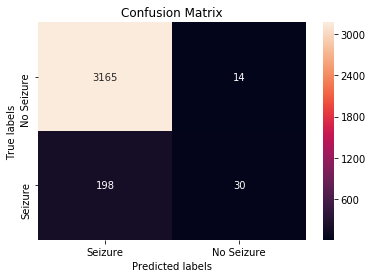

In [6]:
#Logistic Regression Model

x = featuresUnstack.drop(['sz'], axis=1)
y = featuresUnstack['sz']

x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8, test_size=0.2)

#dissimilar scales of data, StandardScaler should be used
sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

lr = LogisticRegression(solver='newton-cg', multi_class='multinomial')
lr.fit(x_train_std,y_train)
y_predict = lr.predict(x_test_std)


print('Accuracy of Logistic Regression Model: %0.2f%%\n\n' % (accuracy_score(y_test,y_predict)*100))

#generate and plot confusion matrix
lr_cm = confusion_matrix(y_test,y_predict)

ax= sns.heatmap(lr_cm, annot=True, fmt="d")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Seizure', 'No Seizure'])
ax.yaxis.set_ticklabels(['No Seizure', 'Seizure'])

#classification report
print(classification_report(y_test,y_predict))

Accuracy of Decision Tree Model: 94.60%


             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3179
          1       0.73      0.31      0.43       228

avg / total       0.94      0.95      0.94      3407



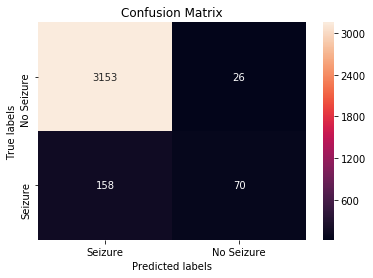

In [7]:
# Decision Tree Classifier
tree_clf = tree.DecisionTreeClassifier(max_depth=9, min_samples_leaf=5)
tree_clf = tree_clf.fit(x_train_std, y_train)

y_predict = tree_clf.predict(x_test_std)
print('Accuracy of Decision Tree Model: %0.2f%%\n\n' % (accuracy_score(y_test,y_predict)*100))

#generate and plot confusion matrix
dTree_cm = confusion_matrix(y_test,y_predict)

ax= sns.heatmap(dTree_cm, annot=True, fmt="d")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Seizure', 'No Seizure'])
ax.yaxis.set_ticklabels(['No Seizure', 'Seizure'])

#classification report
print(classification_report(y_test,y_predict))

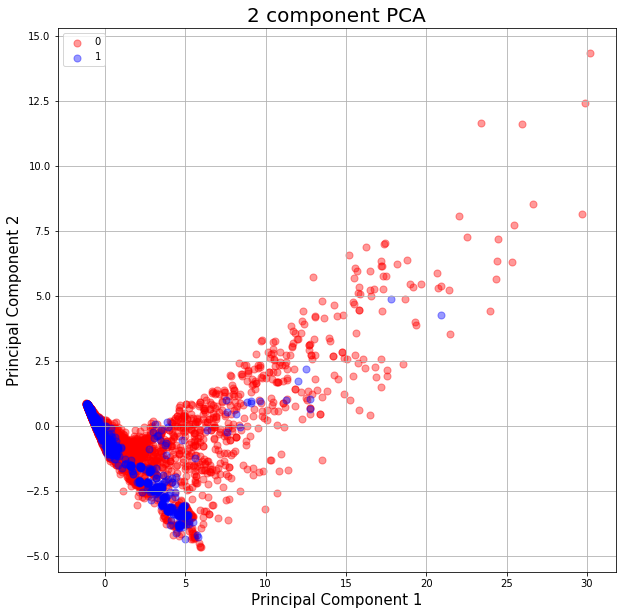

In [8]:
#Dimensionality Reduction/Visualization - PCA
sc2 = StandardScaler().fit(x)
X_std = sc2.transform(x)
pca = PCA(n_components=2,svd_solver='full')
principalComponents = pca.fit_transform(X_std)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, featuresUnstack['sz'].reset_index()], axis = 1)


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0,1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['sz'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50, alpha=0.4)
ax.legend(targets)
ax.grid()

Text(0.5,1,'2 Component TSNE')

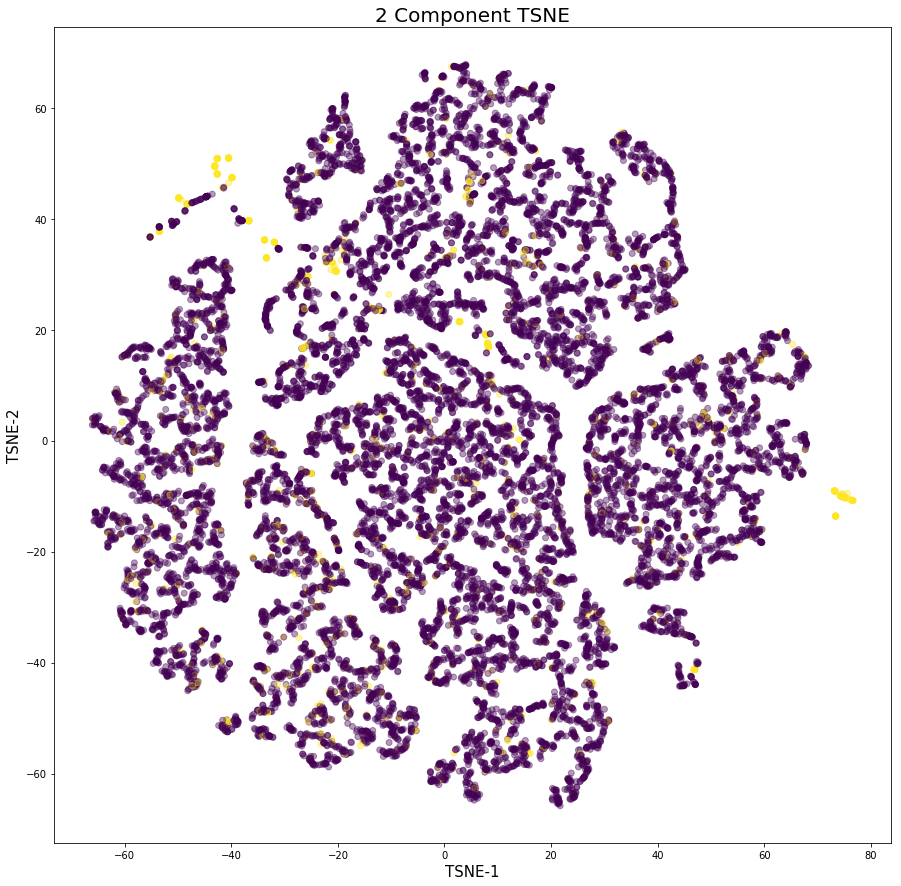

In [11]:
#Dimensionality Reduction/Visualization - TSNE

#ts_results = tsne(X_std)
#tsneObj2 = TSNE(n_components=2, verbose=1, learning_rate=100, perplexity=40)
#ts_results = tsneObj2.fit_transform(X_std)

tsneObj3 = TSNE_Multi(n_components=2, verbose=1, learning_rate=300, perplexity=20, n_jobs=-1)
ts_results = tsneObj3.fit_transform(X_std)


tsne_x = ts_results[:,0]
tsne_y = ts_results[:,1]
plt.figure(figsize=(15,15))
tsne_plot = plt.scatter(tsne_x,tsne_y, c=featuresUnstack['sz'],alpha=0.4)
tsne_plot.axes.set_xlabel('TSNE-1',fontsize=15)
tsne_plot.axes.set_ylabel('TSNE-2', fontsize=15)
tsne_plot.axes.set_title('2 Component TSNE', fontsize=20)